# Dynamic GS-SLAM project
Hossein Azizinaghsh (hossein.azizi@gmail.com)

Mohammad Delkhah (mohammaddelkhah@gmail.com)

# Introduction
Dense simultaneous localization and mapping (SLAM) is pivotal for embodied cene understanding. Recent work has shown that 3D Gaussians enable high-quality reconstruction and real-time rendering of scenes using multiple posed cameras. The paper our work is based on, [SplaTAM](https://github.com/spla-tam/SplaTAM) utilizes Gaussian Splatting to map the scene, and apply localization and tracking based on that reconstruction.

However our baseline and this method in general, behave poorly in scenes with dynamic objects such as people, being unable to differentiate between reliable, static scene structure, and incorrect reconstruction of objects that are no longer there.

Our contribution is to differentiate between static scene structure and dynamic objects, reducing confusion and improving tracking accuracy of the model, and also sometimes creating a cleaner scene structure.

# Main explored ideas

We explored 2 direction to tackle the issue at hand.
1.    **Motion Flow:**   Implementing motion flow extimation to calculate a fundamental matrix describing camera motion, and detecting regions in the captured image corresponding with dynamic objects based on whether they conform to he calculated F or are outliers, ultimately utilizing only static objects for our main process. Our initial experiments showed a flaw in this approach, that when an object is partially or temporarily stationary, they do contribute to the the 3d reconstruction of the scene, which would no longer be valid if at another time the make more significant movements. We concluded that full object masks based on whether an object is potentially dynamic in nature could mitigate this flaw, which weaves in the other idea we were exploring. You can find the codes for these operations on the other uploaded notebook.

<video controls src="Motion Flow Points.mp4" title="Title"></video>

2.   **YOLO:**   In this approach we used YOLO models to identify dynamic objects (basically humans in our chosen dataset) and eliminate them from SLAM process. We investigated various scenarios such as
  *   Elimination from only tracking step vs enire process
  *   Precise object mask vs full bounding box
  *   Enlarging mask to a distance of 7 and 31 pixels
  *   Total loss ignoring vs using current belief (inpainting) in eliminated areas

# Results  
Our results show that using YOLO for elimination of dynamic objects from mapping and tracking processes, without other augmentations, yiels the best improvement, noticably decreasing ATE RMSE over baseline by roughly 30% on average, and up to 50%. Also when evaluating the rendered scene visually, the result seems cleaner, assuming absence of people in it is acceptable, which matches with PSNR metric increase from 14 to 15. Here we can observe that our result (second image) has achieved a better over all reconstruction quality, specially due to its clean right side, compared to baseline (first image):

Baseline reconstruction:

![splatam baseline.jpg](<attachment:splatam baseline.jpg>)

our reconstruction:

![splatam seg mask.jpg](<attachment:splatam seg mask.jpg>)

Using full bounding boxes while yields a smaller improvement, has the advantage of speed, being almost as fast and light weight as baseline.

## Weights and Biases Report
A more detailed comparison of results can be found at [WandB Report](https://api.wandb.ai/links/azizi_delkhah/3tu637lw). We strongly encourage to check that report along with this notebook, since it represents a better view of our experiments and results. Also we're constansly aggregating the data of even more experiments in it, and improving our findings.

++++**We have included a snapshot of current report with our uploaded files.**++++
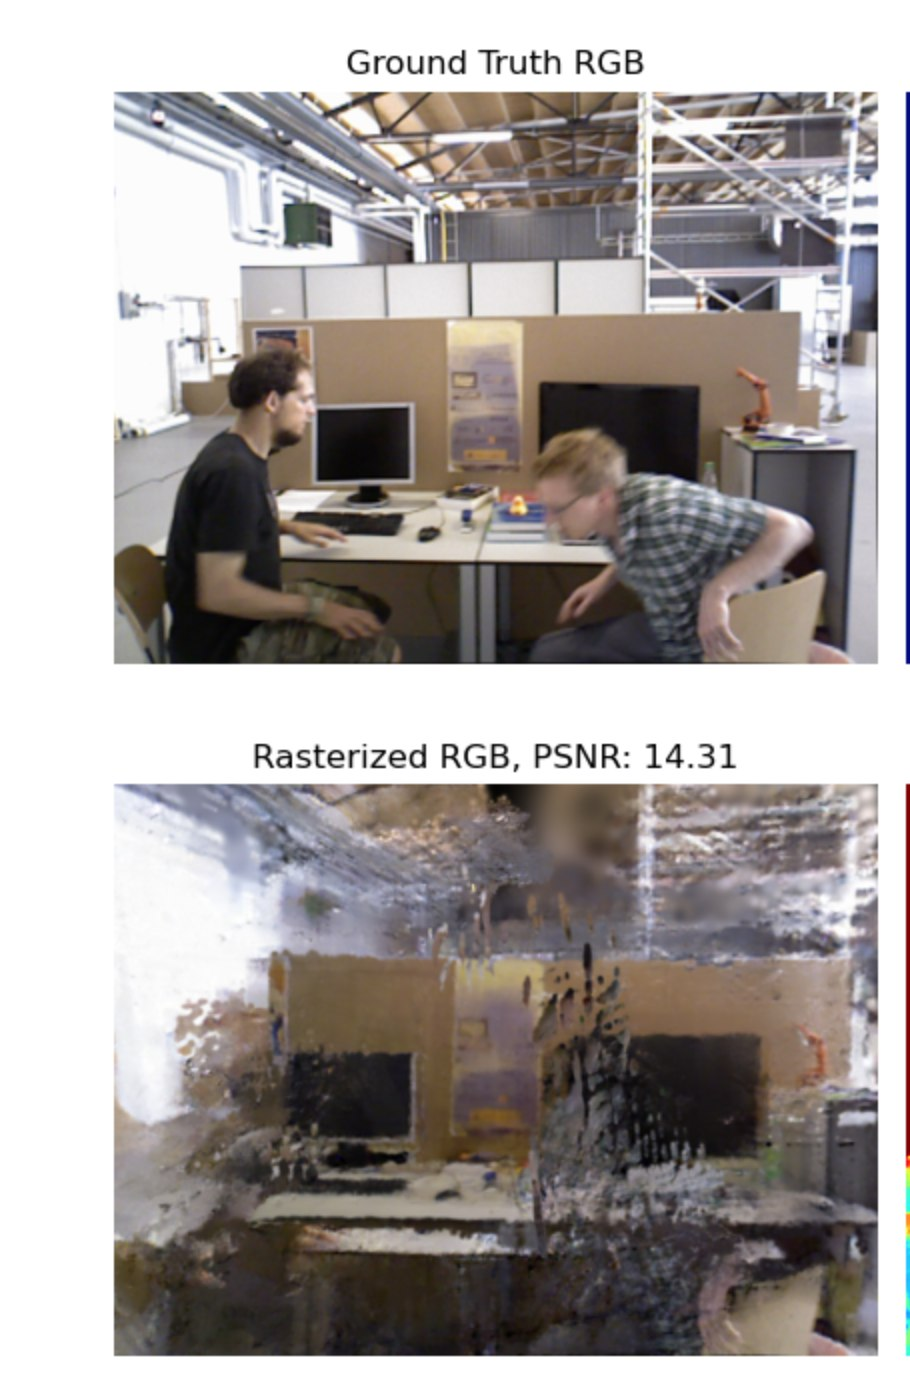
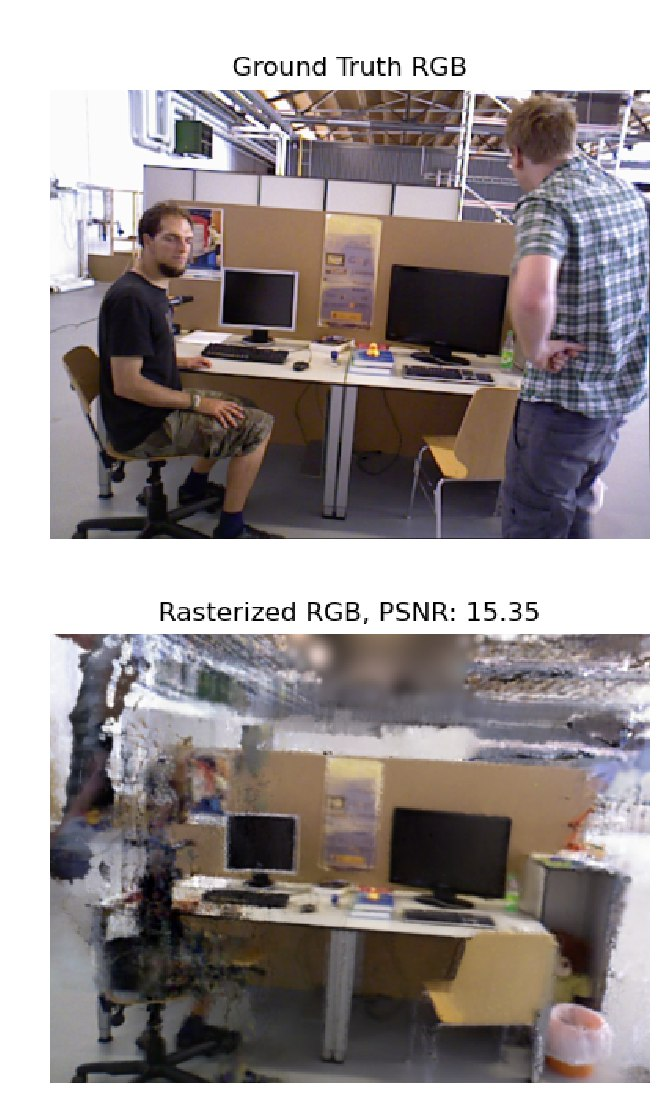

# Cloning source

Here are steps you can follow to run our project on Google Colab. If executing from local source, the next cell isn't needed. Just make sure that the notebook is located at the root of project. (splatam_yolo.py file is located at relative path of scripts/splatam_yolo.py)

In [ ]:
! git clone -b inpainting_merge https://github.com/azizinaghsh/SplaTAM.git
! cp -r SplaTAM/* .
! rm -r SplaTAM/

# Setting up environment
If you don't have the environment and required packages installed (Google Colab), you can execute following cell to install them. If you're using a local environment, you can either use the following cell, or use other methods such as anaconda as described in the README of the project, which is a fork of baseline project.

In [ ]:
! pip install -r requirements.txt
! pip install ultralytics

Cloning into 'SplaTAM'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 211 (delta 81), reused 64 (delta 45), pack-reused 92
Receiving objects: 100% (211/211), 14.34 MiB | 19.48 MiB/s, done.
Resolving deltas: 100% (100/100), done.
  Cloning https://github.com/JonathonLuiten/diff-gaussian-rasterization-w-depth.git (to revision cb65e4b86bc3bd8ed42174b72a62e8d3a3a71110) to /tmp/pip-req-build-x9d2svcz
  Running command git clone --filter=blob:none --quiet https://github.com/JonathonLuiten/diff-gaussian-rasterization-w-depth.git /tmp/pip-req-build-x9d2svcz
  Running command git rev-parse -q --verify 'sha^cb65e4b86bc3bd8ed42174b72a62e8d3a3a71110'
  Running command git fetch -q https://github.com/JonathonLuiten/diff-gaussian-rasterization-w-depth.git cb65e4b86bc3bd8ed42174b72a62e8d3a3a71110
  Resolved https://github.com/JonathonLuiten/diff-gaussian-rasterization-w-depth.git to commit cb65e

# Downlod data sets:

For this project, and due to limited computational resources, we focus on the dynamic scenes from one data set: [TUM RGB-D](https://cvg.cit.tum.de/data/datasets/rgbd-dataset/download).

TUM RGB-D is a large dataset containing RGB-D data and ground-truth data with the goal to establish al benchmark for the evaluation of visual odometry and visual SLAM systems.

The following 2 cells handle download and extraction of each scene of this datasets. Since data for each scene is significantly large, the download process of only one is called. If you wish to download more or change the scene, you can do so by uncommenting other lines.

(Also if you're using this notebook locally, you can run the bash scripts for download, as instructed in the README, similar to baseline. But remember to check the names of the scenes to be dynamic ones, and also create yaml files.)

In [ ]:
import os
import requests
import tarfile
import shutil

def download_and_extract(url, extract_path='./data/TUM_RGBD/', config_file='./configs/data/TUM/freiburg3_long_office_household.yaml'):
    # Get the file name from the url
    file_name = url.split('/')[-1]
    base_name = file_name.split('.')[0]

    prefix = 'rgbd_dataset_'
    if base_name.startswith(prefix):
        base_name = base_name[len(prefix):]


    # Download the file
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_name, 'wb') as f:
            f.write(response.raw.read())

        # Extract the tar file
        with tarfile.open(file_name) as tar:
            tar.extractall(path=extract_path)

        # Duplicate the yaml file
        new_yaml_file = os.path.join(os.path.dirname(config_file), base_name + '.yaml')
        shutil.copy2(config_file, new_yaml_file)
    else:
        print(f"Failed to download {url}. Status code: {response.status_code}")

# Example usage:
# download_and_extract('https://cvg.cit.tum.de/rgbd/dataset/freiburg3/rgbd_dataset_freiburg3_sitting_rpy.tgz')


In [ ]:
#download_and_extract("https://cvg.cit.tum.de/rgbd/dataset/freiburg3/rgbd_dataset_freiburg3_sitting_rpy.tgz")
#download_and_extract("https://cvg.cit.tum.de/rgbd/dataset/freiburg3/rgbd_dataset_freiburg3_sitting_static.tgz")
#download_and_extract("https://cvg.cit.tum.de/rgbd/dataset/freiburg3/rgbd_dataset_freiburg3_sitting_xyz.tgz")
#download_and_extract("https://cvg.cit.tum.de/rgbd/dataset/freiburg3/rgbd_dataset_freiburg3_sitting_halfsphere.tgz")
#download_and_extract("https://cvg.cit.tum.de/rgbd/dataset/freiburg3/rgbd_dataset_freiburg3_walking_static.tgz")
download_and_extract("https://cvg.cit.tum.de/rgbd/dataset/freiburg3/rgbd_dataset_freiburg3_walking_xyz.tgz")
#download_and_extract("https://cvg.cit.tum.de/rgbd/dataset/freiburg3/rgbd_dataset_freiburg3_walking_halfsphere.tgz")
#download_and_extract("https://cvg.cit.tum.de/rgbd/dataset/freiburg3/rgbd_dataset_freiburg3_walking_rpy.tgz")

# Execute
Here the main process of running an experiment is called. In order to tweak options (mask dilation, inpainting, etc) or scene name, you can edit ***configs/tum/splatam.py*** file.
We've also added the option to batch multiple experiments together. You only need enter your desired configurations in *queue* list.

The results will be available in the experiments folder. Also a brief report of stats is shown in the terminal, and in case you have your API key, it can be uploaded to Beights and Biases experiment tracking system.

In [ ]:
! python scripts/splatam_yolo.py configs/tum/splatam.py


System Paths:
/content
/content/scripts
/env/python
/usr/lib/python310.zip
/usr/lib/python3.10
/usr/lib/python3.10/lib-dynload
/usr/local/lib/python3.10/dist-packages
/usr/lib/python3/dist-packages
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100% 233M/233M [00:01<00:00, 125MB/s]
Seed set to: 0 (type: <class 'int'>)
Loaded Config:
{'workdir': './experiments/TUM', 'run_name': 'freiburg3_walking_xyz_seed0_inpaintingTrue_yoloTrue', 'max_frames': 100, 'seed': 0, 'yolo_mapping': True, 'yolo_tracking': True, 'inpainting': True, 'primary_device': 'cuda:0', 'map_every': 1, 'keyframe_every': 5, 'mapping_window_size': 20, 'report_global_progress_every': 500, 'eval_every': 500, 'scene_radius_depth_ratio': 2, 'mean_sq_dist_method': 'projective', 'report_iter_progress': False, 'load_checkpoint': False, 'checkpoint_time_idx': 0, 'save_checkpoints': False, 'checkpoint_interval': 100, 'use_wandb': True, 'wand

# Visualization:
## (the next cells might be broken after lates commit, will be fixed very soon)
If you're running on Google Colab, you can use the next cells to visualize the result of the experiment. However a local execution of visualization is more convenient.
To visualize the results locally, you can execute ***viz_scripts/final_recon.py*** and pass the config file of the experiment you wish to visualize to it, which is located in the experiment folder.

In [ ]:
### CREATE VIRTUAL DISPLAY ###
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'    # tell X clients to use our virtual DISPLAY :1.0.

In [ ]:
import plotly.graph_objects as go
def draw_geometries(geometries):
    graph_objects = []
    print (len(geometries))

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()
        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [ ]:
import argparse
import os
import sys
import time
from importlib.machinery import SourceFileLoader


from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
import torch.nn.functional as F

from diff_gaussian_rasterization import GaussianRasterizer as Renderer
from diff_gaussian_rasterization import GaussianRasterizationSettings as Camera

from utils.common_utils import seed_everything
from utils.recon_helpers import setup_camera
from utils.slam_helpers import get_depth_and_silhouette
from utils.slam_external import build_rotation


def load_camera(cfg, scene_path):
    all_params = dict(np.load(scene_path, allow_pickle=True))
    params = all_params
    org_width = params['org_width']
    org_height = params['org_height']
    w2c = params['w2c']
    intrinsics = params['intrinsics']
    k = intrinsics[:3, :3]

    # Scale intrinsics to match the visualization resolution
    k[0, :] *= cfg['viz_w'] / org_width
    k[1, :] *= cfg['viz_h'] / org_height
    return w2c, k


def load_scene_data(scene_path):
    # Load Scene Data
    all_params = dict(np.load(scene_path, allow_pickle=True))
    all_params = {k: torch.tensor(all_params[k]).cuda().float() for k in all_params.keys()}
    params = all_params

    all_w2cs = []
    num_t = params['cam_unnorm_rots'].shape[-1]
    for t_i in range(num_t):
        cam_rot = F.normalize(params['cam_unnorm_rots'][..., t_i])
        cam_tran = params['cam_trans'][..., t_i]
        rel_w2c = torch.eye(4).cuda().float()
        rel_w2c[:3, :3] = build_rotation(cam_rot)
        rel_w2c[:3, 3] = cam_tran
        all_w2cs.append(rel_w2c.cpu().numpy())

    keys = [k for k in all_params.keys() if
            k not in ['org_width', 'org_height', 'w2c', 'intrinsics',
                      'gt_w2c_all_frames', 'cam_unnorm_rots',
                      'cam_trans', 'keyframe_time_indices']]

    for k in keys:
        if not isinstance(all_params[k], torch.Tensor):
            params[k] = torch.tensor(all_params[k]).cuda().float()
        else:
            params[k] = all_params[k].cuda().float()

    return params, all_w2cs


def get_rendervars(params, w2c, curr_timestep):
    params_timesteps = params['timestep']
    selected_params_idx = params_timesteps <= curr_timestep
    keys = [k for k in params.keys() if
            k not in ['org_width', 'org_height', 'w2c', 'intrinsics',
                      'gt_w2c_all_frames', 'cam_unnorm_rots',
                      'cam_trans', 'keyframe_time_indices']]
    selected_params = deepcopy(params)
    for k in keys:
        selected_params[k] = selected_params[k][selected_params_idx]
    transformed_pts = selected_params['means3D']
    w2c = torch.tensor(w2c).cuda().float()
    rendervar = {
        'means3D': transformed_pts,
        'colors_precomp': selected_params['rgb_colors'],
        'rotations': torch.nn.functional.normalize(selected_params['unnorm_rotations']),
        'opacities': torch.sigmoid(selected_params['logit_opacities']),
        'scales': torch.exp(torch.tile(selected_params['log_scales'], (1, 3))),
        'means2D': torch.zeros_like(selected_params['means3D'], device="cuda")
    }
    depth_rendervar = {
        'means3D': transformed_pts,
        'colors_precomp': get_depth_and_silhouette(transformed_pts, w2c),
        'rotations': torch.nn.functional.normalize(selected_params['unnorm_rotations']),
        'opacities': torch.sigmoid(selected_params['logit_opacities']),
        'scales': torch.exp(torch.tile(selected_params['log_scales'], (1, 3))),
        'means2D': torch.zeros_like(selected_params['means3D'], device="cuda")
    }
    return rendervar, depth_rendervar


def make_lineset(all_pts, all_cols, num_lines):
    linesets = []
    for pts, cols, num_lines in zip(all_pts, all_cols, num_lines):
        lineset = o3d.geometry.LineSet()
        lineset.points = o3d.utility.Vector3dVector(np.ascontiguousarray(pts, np.float64))
        lineset.colors = o3d.utility.Vector3dVector(np.ascontiguousarray(cols, np.float64))
        pt_indices = np.arange(len(lineset.points))
        line_indices = np.stack((pt_indices, pt_indices - num_lines), -1)[num_lines:]
        lineset.lines = o3d.utility.Vector2iVector(np.ascontiguousarray(line_indices, np.int32))
        linesets.append(lineset)
    return linesets


def render(w2c, k, timestep_data, timestep_depth_data, cfg):
    with torch.no_grad():
        cam = setup_camera(cfg['viz_w'], cfg['viz_h'], k, w2c, cfg['viz_near'], cfg['viz_far'])
        white_bg_cam = Camera(
            image_height=cam.image_height,
            image_width=cam.image_width,
            tanfovx=cam.tanfovx,
            tanfovy=cam.tanfovy,
            bg=torch.tensor([1, 1, 1], dtype=torch.float32, device="cuda"),
            scale_modifier=cam.scale_modifier,
            viewmatrix=cam.viewmatrix,
            projmatrix=cam.projmatrix,
            sh_degree=cam.sh_degree,
            campos=cam.campos,
            prefiltered=cam.prefiltered
        )
        im, _, depth, = Renderer(raster_settings=white_bg_cam)(**timestep_data)
        depth_sil, _, _, = Renderer(raster_settings=cam)(**timestep_depth_data)
        differentiable_depth = depth_sil[0, :, :].unsqueeze(0)
        sil = depth_sil[1, :, :].unsqueeze(0)
        return im, depth, sil


def rgbd2pcd(color, depth, w2c, intrinsics, cfg):
    width, height = color.shape[2], color.shape[1]
    CX = intrinsics[0][2]
    CY = intrinsics[1][2]
    FX = intrinsics[0][0]
    FY = intrinsics[1][1]

    # Compute indices
    xx = torch.tile(torch.arange(width).cuda(), (height,))
    yy = torch.repeat_interleave(torch.arange(height).cuda(), width)
    xx = (xx - CX) / FX
    yy = (yy - CY) / FY
    z_depth = depth[0].reshape(-1)

    # Initialize point cloud
    pts_cam = torch.stack((xx * z_depth, yy * z_depth, z_depth), dim=-1)
    pix_ones = torch.ones(height * width, 1).cuda().float()
    pts4 = torch.cat((pts_cam, pix_ones), dim=1)
    c2w = torch.inverse(torch.tensor(w2c).cuda().float())
    pts = (c2w @ pts4.T).T[:, :3]

    # Convert to Open3D format
    pts = o3d.utility.Vector3dVector(pts.contiguous().double().cpu().numpy())

    # Colorize point cloud
    if cfg['render_mode'] == 'depth':
        cols = z_depth
        bg_mask = (cols < 15).float()
        cols = cols * bg_mask
        colormap = plt.get_cmap('jet')
        cNorm = plt.Normalize(vmin=0, vmax=torch.max(cols))
        scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=colormap)
        cols = scalarMap.to_rgba(cols.contiguous().cpu().numpy())[:, :3]
        bg_mask = bg_mask.cpu().numpy()
        cols = cols * bg_mask[:, None] + (1 - bg_mask[:, None]) * np.array([1.0, 1.0, 1.0])
        cols = o3d.utility.Vector3dVector(cols)
    else:
        cols = torch.permute(color, (1, 2, 0)).reshape(-1, 3)
        cols = o3d.utility.Vector3dVector(cols.contiguous().double().cpu().numpy())
    return pts, cols


def visualize(scene_path, cfg):
    # Load Scene Data
    first_frame_w2c, k = load_camera(cfg, scene_path)

    params, all_w2cs = load_scene_data(scene_path)
    print(params['means3D'].shape)
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=int(cfg['viz_w'] * cfg['view_scale']),
                      height=int(cfg['viz_h'] * cfg['view_scale']),
                      visible=True)

    scene_data, scene_depth_data = get_rendervars(params, first_frame_w2c, curr_timestep=0)
    im, depth, sil = render(first_frame_w2c, k, scene_data, scene_depth_data, cfg)
    init_pts, init_cols = rgbd2pcd(im, depth, first_frame_w2c, k, cfg)
    pcd = o3d.geometry.PointCloud()
    pcd.points = init_pts
    pcd.colors = init_cols
    vis.add_geometry(pcd)

    w = cfg['viz_w']
    h = cfg['viz_h']

    # Initialize Estimated Camera Frustums
    frustum_size = 0.045
    num_t = len(all_w2cs)
    cam_centers = []
    cam_colormap = plt.get_cmap('cool')
    norm_factor = 0.5
    total_num_lines = num_t - 1
    line_colormap = plt.get_cmap('cool')

    # Initialize View Control
    view_k = k * cfg['view_scale']
    view_k[2, 2] = 1
    view_control = vis.get_view_control()
    cparams = o3d.camera.PinholeCameraParameters()
    first_view_w2c = first_frame_w2c
    first_view_w2c[:3, 3] = first_view_w2c[:3, 3] + np.array([0, 0, 0.5])
    cparams.extrinsic = first_view_w2c
    cparams.intrinsic.intrinsic_matrix = view_k
    cparams.intrinsic.height = int(cfg['viz_h'] * cfg['view_scale'])
    cparams.intrinsic.width = int(cfg['viz_w'] * cfg['view_scale'])
    view_control.convert_from_pinhole_camera_parameters(cparams, allow_arbitrary=True)

    render_options = vis.get_render_option()
    render_options.point_size = cfg['view_scale']
    render_options.light_on = False

    # Rendering of Online Reconstruction
    start_time = time.time()
    num_timesteps = num_t
    viz_start = True
    curr_timestep = 0
    while curr_timestep < (num_timesteps-1) or not cfg['enter_interactive_post_online']:
        passed_time = time.time() - start_time
        passed_frames = passed_time * cfg['viz_fps']
        curr_timestep = int(passed_frames % num_timesteps)
        if not viz_start:
            if curr_timestep == prev_timestep:
                continue

        # Update Camera Frustum
        if curr_timestep == 0:
            cam_centers = []
            if not viz_start:
                vis.remove_geometry(prev_lines)
        if not viz_start:
            vis.remove_geometry(prev_frustum)
        new_frustum = o3d.geometry.LineSet.create_camera_visualization(w, h, k, all_w2cs[curr_timestep], frustum_size)
        new_frustum.paint_uniform_color(np.array(cam_colormap(curr_timestep * norm_factor / num_t)[:3]))
        vis.add_geometry(new_frustum)
        prev_frustum = new_frustum
        cam_centers.append(np.linalg.inv(all_w2cs[curr_timestep])[:3, 3])

        # Update Camera Trajectory
        if len(cam_centers) > 1 and curr_timestep > 0:
            num_lines = [1]
            cols = []
            for line_t in range(curr_timestep):
                cols.append(np.array(line_colormap((line_t * norm_factor / total_num_lines)+norm_factor)[:3]))
            cols = np.array(cols)
            all_cols = [cols]
            out_pts = [np.array(cam_centers)]
            linesets = make_lineset(out_pts, all_cols, num_lines)
            lines = o3d.geometry.LineSet()
            lines.points = linesets[0].points
            lines.colors = linesets[0].colors
            lines.lines = linesets[0].lines
            vis.add_geometry(lines)
            prev_lines = lines
        elif not viz_start:
            vis.remove_geometry(prev_lines)

        # Get Current View Camera
        cam_params = view_control.convert_to_pinhole_camera_parameters()
        view_k = cam_params.intrinsic.intrinsic_matrix
        k = view_k / cfg['view_scale']
        k[2, 2] = 1
        view_w2c = cam_params.extrinsic
        view_w2c = np.dot(first_view_w2c, all_w2cs[curr_timestep])
        cam_params.extrinsic = view_w2c
        view_control.convert_from_pinhole_camera_parameters(cam_params, allow_arbitrary=True)

        scene_data, scene_depth_data = get_rendervars(params, view_w2c, curr_timestep=curr_timestep)
        if cfg['render_mode'] == 'centers':
            pts = o3d.utility.Vector3dVector(scene_data['means3D'].contiguous().double().cpu().numpy())
            cols = o3d.utility.Vector3dVector(scene_data['colors_precomp'].contiguous().double().cpu().numpy())
        else:
            im, depth, sil = render(view_w2c, k, scene_data, scene_depth_data, cfg)
            if cfg['show_sil']:
                im = (1-sil).repeat(3, 1, 1)
            pts, cols = rgbd2pcd(im, depth, view_w2c, k, cfg)

        # Update Gaussians
        pcd.points = pts
        pcd.colors = cols
        vis.update_geometry(pcd)

        if not vis.poll_events():
            break
        vis.update_renderer()
        prev_timestep = curr_timestep
        viz_start = False
        # Capture the current rendered window
        # Capture the current rendered window




        return pcd

    # Cleanup
    vis.destroy_window()
    del view_control
    del vis
    del render_options



args = "configs/tum/splatam.py"

experiment = SourceFileLoader(
    os.path.basename(args), args
).load_module()

seed_everything(seed=experiment.config["seed"])

if "scene_path" not in experiment.config:
    results_dir = os.path.join(
        experiment.config["workdir"], experiment.config["run_name"]
    )
    scene_path = os.path.join(results_dir, "params.npz")
else:
    scene_path = experiment.config["scene_path"]
viz_cfg = experiment.config["viz"]

# Visualize Final Reconstruction
#pcd =visualize(scene_path, viz_cfg)
#draw_geometries([pcd])

